1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


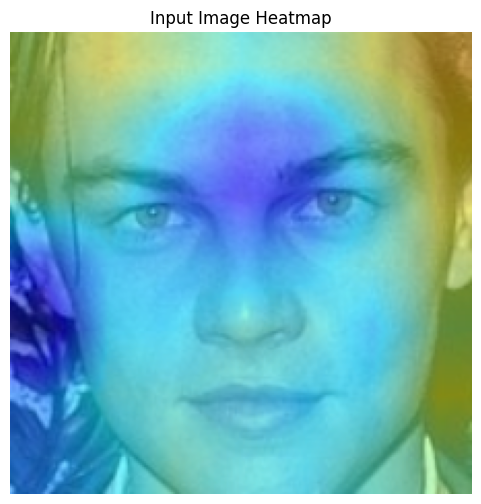

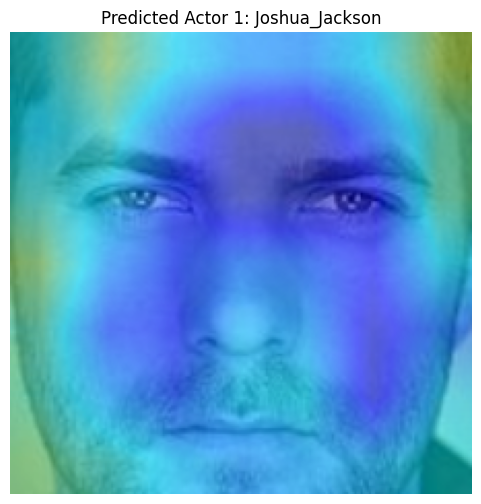

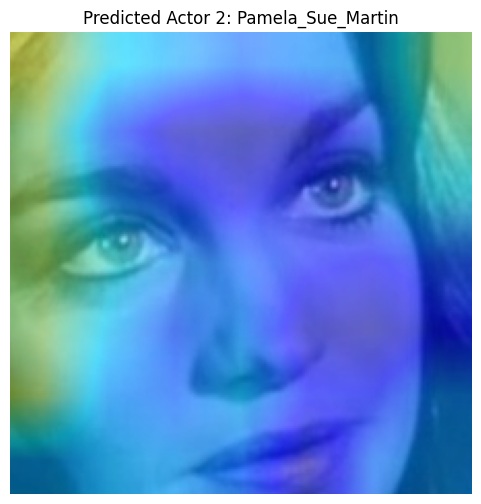

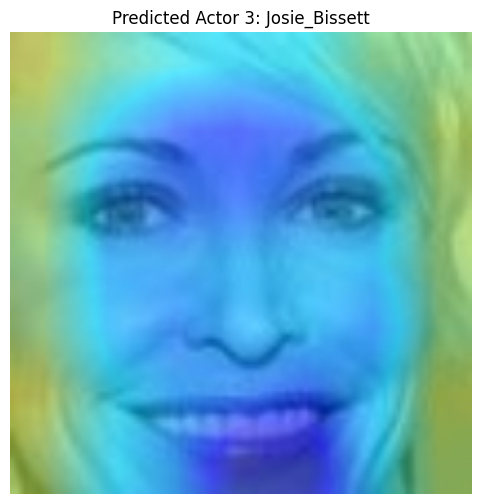

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import glob
import json
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Configuration
IMG_SIZE = (224, 224)
NUM_CENTROIDS_PER_PERSON = 16
NUM_PEOPLE = 488

# Load model and data
base_model = load_model('../models/resnet50.h5')
feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

pca_model = joblib.load('../models/kmeans_k=16/pca_model.pkl')
kmeans_models = [joblib.load(path) for path in glob.glob('../models/kmeans_k=16/kmeans_label_*.pkl')]
all_centroids = np.concatenate([model.cluster_centers_ for model in kmeans_models], axis=0)

with open("../feature_maps/class_indices.json", "r") as f:
    index_to_class = {v: k for k, v in json.load(f).items()}

def detect_and_crop_face(image_path):
    image = cv2.imread(image_path)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        print("No faces detected, using original image.")
        return image  
    
    x, y, w, h = faces[0] 
    return image[y:y+h, x:x+w]

def preprocess_image(img_path):
    img = detect_and_crop_face(img_path)
    img = cv2.resize(img, IMG_SIZE)
    img_array = image.img_to_array(img)
    return preprocess_input(np.expand_dims(img_array, axis=0)), img

def extract_feature_map(img_path):
    img_array, _ = preprocess_image(img_path)
    feature_maps = feature_extractor.predict(img_array)
    feature_vector = feature_maps.reshape(1, -1)
    return pca_model.transform(feature_vector)

def find_closest_people(img_path, num_people=3):
    feature_vector_reduced = extract_feature_map(img_path)
    distances = np.linalg.norm(all_centroids - feature_vector_reduced, axis=1)
    closest_centroids = np.argsort(distances)[:num_people * NUM_CENTROIDS_PER_PERSON]
    closest_people = set(closest_centroids // NUM_CENTROIDS_PER_PERSON)
    return [index_to_class.get(person, "Unknown") for person in list(closest_people)[:num_people]]

def load_predicted_people_images(predicted_people, train_dir="../data/train"):
    images = {}
    for person in predicted_people:
        img_paths = glob.glob(os.path.join(train_dir, person, "*.jpeg"))
        if img_paths:
            images[person] = img_paths[0]
    return images

def compute_gradcam(model, img_array, layer_name='conv5_block3_out'):
    grad_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, preds = grad_model(img_array)
        class_idx = np.clip(np.argmax(preds[0]), 0, preds.shape[1] - 1)
        loss = preds[:, class_idx]
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = np.maximum(tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)[0], 0)
    return heatmap / np.max(heatmap)

def overlay_heatmap(img, heatmap):
    heatmap = cv2.applyColorMap(cv2.resize((heatmap * 255).astype(np.uint8), (img.shape[1], img.shape[0])), cv2.COLORMAP_JET)
    return cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

def visualize_heatmaps(img_path):
    predicted_people = find_closest_people(img_path)
    predicted_images = load_predicted_people_images(predicted_people)
    input_array, input_img = preprocess_image(img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay_heatmap(input_img, compute_gradcam(feature_extractor, input_array)))
    plt.title("Input Image Heatmap")
    plt.axis("off")
    plt.show()
    
    for i, (person, img_path) in enumerate(predicted_images.items()):
        img_array, img = preprocess_image(img_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(overlay_heatmap(img, compute_gradcam(feature_extractor, img_array)))
        plt.title(f"Predicted Actor {i+1}: {person}")
        plt.axis("off")
        plt.show()

input_img_path = '../temp/96da7f48-6a56-4aaa-897c-6ed2a5d9989e.jpg'
visualize_heatmaps(input_img_path)